In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import pathlib
import seaborn as sns
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import pybedtools
from amb import *
import seaborn  as sns
from amb import *
import numpy as np
import joblib
import pyBigWig

In [2]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi']=300
plt.rcParams['pdf.fonttype']=42

In [3]:
shared_cts = joblib.load('/home/qzeng/project/aging/metadata/shared_use_cts')
admr_dir = 'mC_FILTER_DMR_BED/'

ordered_shared_cts = [  'Astro-NT NN','Astro-TE NN','Microglia NN','OPC NN','Oligo NN',
 'L2/3 IT CTX Glut','L4/5 IT CTX Glut','L5 IT CTX Glut','L6 IT CTX Glut',
 'L6 CT CTX Glut',  'L5 ET CTX Glut',  'L5 NP CTX Glut',   'L6b/CT ENT Glut','L2/3 IT ENT Glut',                               
 'L2/3 IT PPP Glut', 'CA1-ProS Glut','CA3 Glut','DG Glut','SUB-ProS Glut','LA-BLA-BMA-PA Glut',
 'MEA-COA Glut','PAG Glut','PB Evx2 Glut',
 'Lamp5 Gaba','Vip Gaba','Pvalb Gaba','Sst Gaba',
 'MEA-BST Gaba','CEA-BST Gaba','LDT-PCG-CS Gata3 Lhx1 Gaba','PAG-PPN Pax5 Sox21 Gaba',
 'STR-PAL Chst9 Gaba', 'STR D1 Sema5a Gaba','STR D1 Gaba','STR D2 Gaba','STR Gaba',
 ]
len(ordered_shared_cts)


36

In [4]:
# plot_cts = ['OPC_NN','DG_Glut', 'STR_D1_Gaba', 'Oligo_NN', 'STR_D2_Gaba', 'CA1-ProS_Glut',
#        'Astro-TE_NN', 'L6_CT_CTX_Glut', 'L23_IT_CTX_Glut', 'CA3_Glut',
#        'CEA-BST_Gaba', 'L45_IT_CTX_Glut', 'MEA-COA_Glut', 'L6bCT_ENT_Glut',
#        'L23_IT_PPP_Glut', 'Microglia_NN', 'STR-PAL_Chst9_Gaba','STR_D1_Gaba', 'PAG_Glut',
#         'Sst_Gaba','Lamp5 _Gaba','Pvalb_Gaba','Vip_Gaba',
#        'LA-BLA-BMA-PA_Glut', 'L23_IT_ENT_Glut', 'L6_IT_CTX_Glut']
# len(plot_cts)

In [4]:
#ordered_plot_cts = [ct for ct in ordered_shared_cts if ct.replace('/','').replace(' ','_')  in plot_cts]
use_cts = [ct.replace('/','').replace(' ','_') for ct in ordered_shared_cts]
len(use_cts)


36

## get values

In [25]:
all_beds = []

for ct in use_cts:
    path = f"{admr_dir}/{ct}.Hypo.aDMR.bed"
    tmpdf = pd.read_csv(path, sep = '\t', header = None)
    tmpdf['celltype'] = ct
    tmpdf = tmpdf[tmpdf[0] != 'chrX'][[3, 'celltype']]
    # if tmpdf.shape[0] > 500:
    #     tmpdf = tmpdf.sample(500)
    # else:
    #     tmpdf = tmpdf
    # if tmpdf.shape[0] > 2000:
    #     sample_dmr_num = int(tmpdf.shape[0]/20)
    #     tmpdf = tmpdf.sample(sample_dmr_num)
    # else: 
    #     tmpdf = tmpdf
    all_beds.append(tmpdf)

all_beds = pd.concat(all_beds, axis = 0).set_index(3)
duplicated_indices = all_beds.index.duplicated(keep=False)
all_beds = all_beds[~duplicated_indices]

dmr_list = all_beds.index

In [26]:
print(len(dmr_list))

155657


In [8]:
## get aDMR mC counts
mc_dir = '/ceph/gale-1/qzeng/AmbData/CellType_Allc/M.CellType.Age'

def get_mc_mean(age, ct, dmr_list):
    bigwig_path = f"{mc_dir}/{ct}.{age}/{ct}.{age}.CGN-both.frac.bw"
    bw = pyBigWig.open(bigwig_path)
    total_counts = []
    for dmr_id in dmr_list:
        slop = 0
        _chr, start, end = dmr_id.split('-')
        start, end = int(start)-slop, int(end) + slop
        counts = bw.stats(_chr, start, end, type="mean")[0]
        total_counts.append(counts)
    tmpdf = pd.DataFrame({age:total_counts}, index = dmr_list)
    return tmpdf


In [9]:
age_list = ['8wk','18mo']

all_mc_df = []
for ct in use_cts:
    ct_mc = []
    for age in age_list:
        tmpdf = get_mc_mean(age, ct, dmr_list)
        ct_mc.append(tmpdf)
    
    ct_mc = pd.concat(ct_mc, axis = 1)
    #ct_mc['change'] = ct_mc['18mo'] - ct_mc['8wk']
    ct_mc['change'] = ct_mc['8wk'] - ct_mc['18mo']
    ct_mc = ct_mc[['change']]
    ct_mc.columns = [ct]
    all_mc_df.append(ct_mc)
    print(ct)

Astro-NT_NN
Astro-TE_NN
Microglia_NN
OPC_NN
Oligo_NN
L23_IT_CTX_Glut
L45_IT_CTX_Glut
L5_IT_CTX_Glut
L6_IT_CTX_Glut
L6_CT_CTX_Glut
L5_ET_CTX_Glut
L5_NP_CTX_Glut
L6bCT_ENT_Glut
L23_IT_ENT_Glut
L23_IT_PPP_Glut
CA1-ProS_Glut
CA3_Glut
DG_Glut
SUB-ProS_Glut
LA-BLA-BMA-PA_Glut
MEA-COA_Glut
PAG_Glut
PB_Evx2_Glut
Lamp5_Gaba
Vip_Gaba
Pvalb_Gaba
Sst_Gaba
MEA-BST_Gaba
CEA-BST_Gaba
LDT-PCG-CS_Gata3_Lhx1_Gaba
PAG-PPN_Pax5_Sox21_Gaba
STR-PAL_Chst9_Gaba
STR_D1_Sema5a_Gaba
STR_D1_Gaba
STR_D2_Gaba
STR_Gaba


In [10]:
all_mc_df = pd.concat(all_mc_df, axis = 1)
all_mc_df.head()

,Astro-NT_NN,Astro-TE_NN,Microglia_NN,OPC_NN,Oligo_NN,L23_IT_CTX_Glut,L45_IT_CTX_Glut,L5_IT_CTX_Glut,L6_IT_CTX_Glut,L6_CT_CTX_Glut,...,Sst_Gaba,MEA-BST_Gaba,CEA-BST_Gaba,LDT-PCG-CS_Gata3_Lhx1_Gaba,PAG-PPN_Pax5_Sox21_Gaba,STR-PAL_Chst9_Gaba,STR_D1_Sema5a_Gaba,STR_D1_Gaba,STR_D2_Gaba,STR_Gaba
3,,,,,,,,,,,,,,,,,,,,,
chr1-3149493-3149499,-0.600000,0.043798,0.063024,0.001288,0.027710,-0.039593,-0.029212,0.095960,0.098794,0.048419,...,-0.045525,0.134821,-0.038095,0.166667,-0.019608,-0.035304,-0.038889,-0.005945,0.015457,-0.022222
chr1-3155400-3155481,-0.406575,0.085914,0.132559,-0.109098,0.102347,-0.016580,0.037454,0.035137,-0.044425,0.051561,...,-0.050937,0.024181,-0.017573,0.017094,-0.065083,-0.013985,-0.090042,0.005867,-0.081274,-0.033765
chr1-3188443-3188741,-0.279694,-0.062472,-0.085903,-0.045325,0.021216,-0.027087,0.048868,-0.030399,-0.005830,-0.008691,...,0.007830,0.086961,0.044610,0.099015,0.000000,0.074883,-0.039519,-0.018998,0.004514,0.077927
chr1-3190961-3191346,-0.295041,0.083277,-0.013609,0.012032,0.047340,-0.060417,0.053140,-0.010219,0.132260,0.064807,...,-0.050147,0.001358,-0.051651,-0.050505,-0.189394,0.082354,0.015007,0.000290,-0.012307,-0.000562
chr1-3259956-3260172,-0.322076,-0.080232,-0.165998,0.052567,-0.037286,0.166843,-0.033859,-0.005783,-0.044828,-0.017621,...,-0.020869,-0.068900,0.000016,0.001709,-0.098876,-0.026255,-0.084283,0.004346,0.021602,-0.118329


In [11]:
all_mc_df.to_csv('all-hyper.all_mc_df.csv')

In [12]:
all_beds.to_csv('all-hyper.all_beds.csv')

## plot heatmap

In [41]:
all_mc_df = pd.read_csv('all-hyper.all_mc_df.csv', index_col =0)
all_beds = pd.read_csv('all-hyper.all_beds.csv', index_col =0)

In [15]:
import PyComplexHeatmap as pch
from PyComplexHeatmap import *
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi']=300
plt.rcParams['pdf.fonttype']=42

In [16]:
import joblib
mt_pelatte = joblib.load('/home/qzeng/project/aging/231117_update_annot/AgingMajorType_Palette')

new_mt_palette = {}
for mt ,_color in mt_pelatte.items():
    mt= mt.replace('/','').replace(' ','_')
    new_mt_palette[mt] = _color

In [17]:
row_annot = all_beds.copy()
row_annot['celltype_annot'] = row_annot['celltype']
row_annot['celltype_annot'] = [' '.join(ct.split('_')[:-1]) for ct in row_annot['celltype']]
row_annot.head()

,celltype,celltype_annot
3,,
chr1-3149493-3149499,Astro-NT_NN,Astro-NT
chr1-3155400-3155481,Astro-NT_NN,Astro-NT
chr1-3188443-3188741,Astro-NT_NN,Astro-NT
chr1-3190961-3191346,Astro-NT_NN,Astro-NT
chr1-3259956-3260172,Astro-NT_NN,Astro-NT


In [18]:
col_annot = pd.DataFrame({'celltype':[ct.replace(' ','_').replace('/','') for ct in ordered_shared_cts]})
col_annot.index= col_annot.celltype
col_annot.index.name = 'celltype'
col_annot['celltype'] = [' '.join(ct.split('_')[:-1]) for ct in col_annot['celltype']]
col_annot.head()

,celltype
celltype,
Astro-NT,Astro-NT
Astro-TE,Astro-TE
Microglia,Microglia
OPC,OPC
Oligo,Oligo


In [19]:
left_ha = pch.HeatmapAnnotation(
                          label=pch.anno_label(row_annot.celltype_annot,merge=True,extend=False,
                                               adjust_color=True,luminance=0.75,relpos=(1,0.5), colors = 'black'), #,
                           AgeDMRs=pch.anno_simple(row_annot.celltype,legend=True,colors= new_mt_palette),
                           verbose=1,axis=0,plot_legend=False)

In [20]:
col_ha = pch.HeatmapAnnotation(
    # label=pch.anno_label(col_annot.celltype,merge=True,rotation=90,
    #                      extend=True,colors= new_mt_palette,relpos=(0.5,0)
    #                     ), #fontsize=10
   celltype=pch.anno_simple(col_annot.celltype,legend=False,  colors=new_mt_palette),
   verbose=1,axis=1)

In [21]:
plot_mc_df = all_mc_df.dropna()

In [22]:
plot_mc_df.shape

(118233, 36)

In [23]:
plot_mc_df.columns = [' '.join(ct.split('_')[:-1]) for ct in plot_mc_df.columns]

In [42]:
all_mc_df

,Astro-NT_NN,Astro-TE_NN,Microglia_NN,OPC_NN,Oligo_NN,L23_IT_CTX_Glut,L45_IT_CTX_Glut,L5_IT_CTX_Glut,L6_IT_CTX_Glut,L6_CT_CTX_Glut,...,Sst_Gaba,MEA-BST_Gaba,CEA-BST_Gaba,LDT-PCG-CS_Gata3_Lhx1_Gaba,PAG-PPN_Pax5_Sox21_Gaba,STR-PAL_Chst9_Gaba,STR_D1_Sema5a_Gaba,STR_D1_Gaba,STR_D2_Gaba,STR_Gaba
3,,,,,,,,,,,,,,,,,,,,,
chr1-3149493-3149499,-0.600000,0.043798,0.063024,0.001288,0.027710,-0.039593,-0.029212,0.095960,0.098794,0.048419,...,-0.045525,0.134821,-0.038095,0.166667,-0.019608,-0.035304,-0.038889,-0.005945,0.015457,-0.022222
chr1-3155400-3155481,-0.406575,0.085914,0.132559,-0.109098,0.102347,-0.016580,0.037454,0.035137,-0.044425,0.051561,...,-0.050937,0.024181,-0.017573,0.017094,-0.065083,-0.013985,-0.090042,0.005867,-0.081274,-0.033765
chr1-3188443-3188741,-0.279694,-0.062472,-0.085903,-0.045325,0.021216,-0.027087,0.048868,-0.030399,-0.005830,-0.008691,...,0.007830,0.086961,0.044610,0.099015,0.000000,0.074883,-0.039519,-0.018998,0.004514,0.077927
chr1-3190961-3191346,-0.295041,0.083277,-0.013609,0.012032,0.047340,-0.060417,0.053140,-0.010219,0.132260,0.064807,...,-0.050147,0.001358,-0.051651,-0.050505,-0.189394,0.082354,0.015007,0.000290,-0.012307,-0.000562
chr1-3259956-3260172,-0.322076,-0.080232,-0.165998,0.052567,-0.037286,0.166843,-0.033859,-0.005783,-0.044828,-0.017621,...,-0.020869,-0.068900,0.000016,0.001709,-0.098876,-0.026255,-0.084283,0.004346,0.021602,-0.118329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr9-120716726-120716814,-0.154762,0.012508,0.011753,-0.219907,0.056258,0.147827,0.155605,0.321193,0.066001,-0.210928,...,-0.060717,0.076037,0.089615,-0.054762,0.045833,-0.058642,-0.026967,0.089554,0.143841,-0.226190
chr9-121370322-121370378,0.006217,-0.018127,-0.084117,0.107606,-0.000371,0.004890,-0.051222,0.006173,0.023298,-0.011078,...,-0.136884,-0.163345,-0.042211,-0.166667,0.000000,-0.081033,0.087771,-0.000615,0.023870,-0.164566
chr9-121764288-121764319,0.305556,-0.020145,0.030590,0.093349,-0.068853,0.096706,-0.124505,-0.059885,0.060195,0.139508,...,-0.072207,-0.062279,0.034641,-0.500000,-0.177881,-0.015961,-0.068023,0.048238,0.008642,-0.492375


Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 7.5 mm


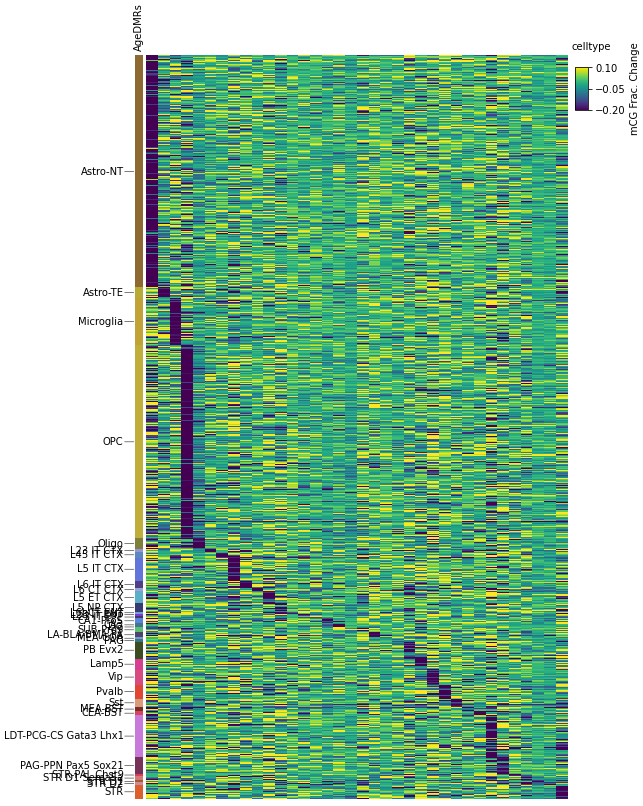

In [24]:
plt.figure(figsize=(8, 12))

cm = ClusterMapPlotter(
        data=plot_mc_df, 
        top_annotation=col_ha,left_annotation=left_ha,
        vmin = -0.2, vmax = 0.1,
        col_cluster=False,row_cluster=False,
        label = 'mCG Frac. Change',
        cmap='viridis',rasterized=True,
        xticklabels_kws={'labelrotation':0,'labelcolor':'blue'}
        )
plt.savefig(f"figure/allDMR-hyper-all.pycomplex.celltype.admr.heatmap.pdf", bbox_inches='tight')
plt.show()

## plot cell types var

In [29]:
colors = [new_mt_palette[ct] for ct in use_cts]

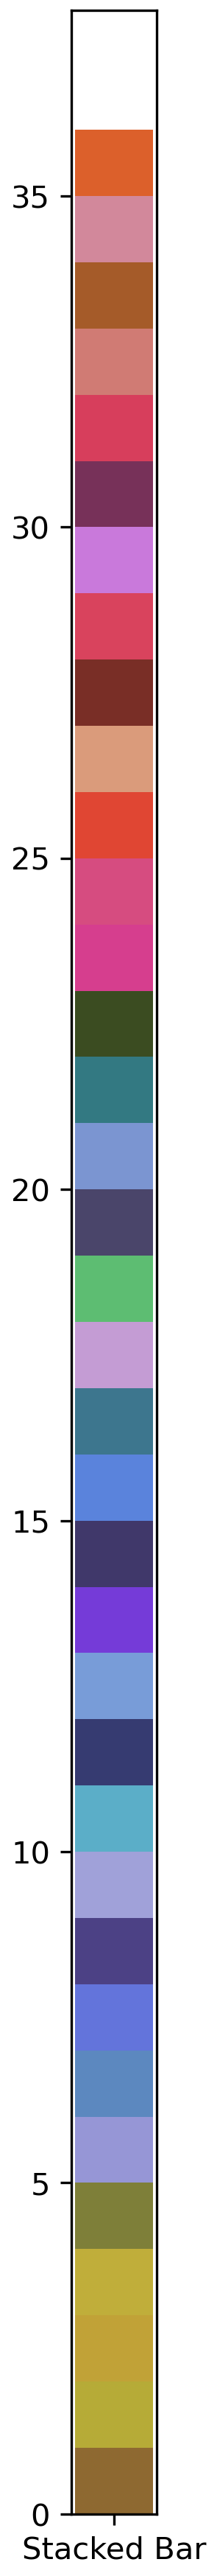

In [40]:
fig, ax = plt.subplots(figsize=(0.5,15), dpi = 300)
data = [1] * len(use_cts)
start = 0
for idx, (category, color) in enumerate(zip(use_cts, colors)):
    ax.bar('Stacked Bar', data[idx], bottom=start, color=color, label=category)
    start += data[idx]

fig.savefig('celltype_order_bar.pdf', bbox_inches = 'tight')